<!--BOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="figures/PDSH-cover-small.png">

*This notebook contains an excerpt from the [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas; the content is available [on GitHub](https://github.com/yongduek/PythonDataScienceHandbook).*

*The text is released under the [CC-BY-NC-ND license](https://creativecommons.org/licenses/by-nc-nd/3.0/us/legalcode), and code is released under the [MIT license](https://opensource.org/licenses/MIT). If you find this content useful, please consider supporting the work by [buying the book](http://shop.oreilly.com/product/0636920034919.do)!*

<!--NAVIGATION-->
< [In Depth: Linear Regression](05.06-Linear-Regression.ipynb) | [Contents](Index.ipynb) | [In-Depth: Decision Trees and Random Forests](05.08-Random-Forests.ipynb) >

<a href="https://colab.research.google.com/github/yongduek/PythonDataScienceHandbook/blob/master/notebooks/05.07-Support-Vector-Machines.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>


# In-Depth: Support Vector Machines

Support vector machines (SVMs) are a particularly powerful and flexible class of supervised algorithms for both classification and regression.
In this section, we will develop the intuition behind support vector machines and their use in classification problems.

We begin with the standard imports:

In [12]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (8,5)
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

## Motivating Support Vector Machines

As part of our disussion of Bayesian classification (see [In Depth: Naive Bayes Classification](05.05-Naive-Bayes.ipynb)), we learned a simple model describing the distribution of each underlying class, and used these generative models to probabilistically determine labels for new points.
That was an example of *generative classification*; here we will consider instead *discriminative classification*: rather than modeling each class, we simply find a line or curve (in two dimensions) or manifold (in multiple dimensions) that divides the classes from each other.

As an example of this, consider the simple case of a classification task, in which the two classes of points are well separated:

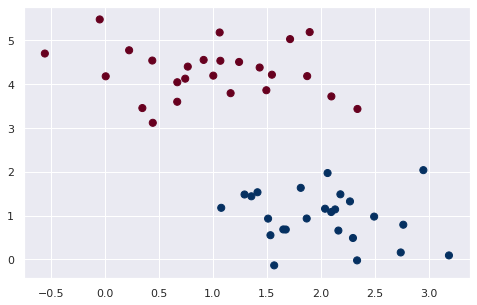

In [13]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu');

A linear discriminative classifier would attempt to draw a straight line separating the two sets of data, and thereby create a model for classification.
For two dimensional data like that shown here, this is a task we could do by hand.
But immediately we see a problem: there is more than one possible dividing line that can perfectly discriminate between the two classes!

We can draw them as follows:

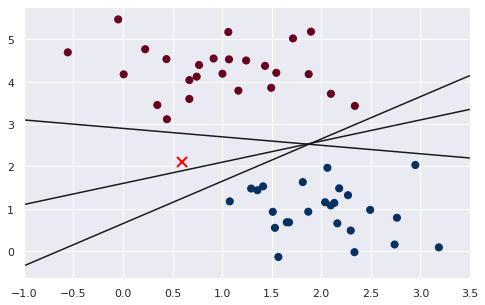

In [14]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

These are three *very* different separators which, nevertheless, perfectly discriminate between these samples.
Depending on which you choose, a new data point (e.g., the one marked by the "X" in this plot) will be assigned a different label!
Evidently our simple intuition of "drawing a line between classes" is not enough, and we need to think a bit deeper.

## Support Vector Machines: Maximizing the *Margin*

Support vector machines offer one way to improve on this.
The intuition is this: rather than simply drawing a zero-width line between the classes, we can draw around each line a *margin* of some width, up to the nearest point.
Here is an example of how this might look:

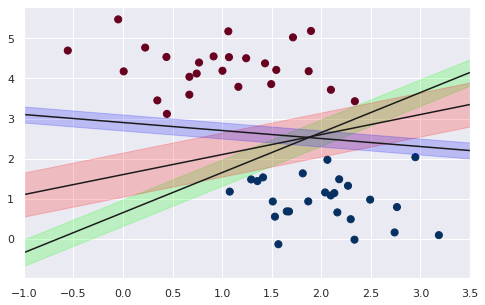

In [15]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')

colors = ['#00FF00', '#FF0000', '#0000FF']
i = 0
for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color=colors[i], alpha=0.2)
    i += 1

plt.xlim(-1, 3.5);

In support vector machines, the line that maximizes this margin is the one we will choose as the optimal model.
Support vector machines are an example of such a *maximum margin* estimator.

### Fitting a support vector machine

Let's see the result of an actual fit to this data: we will use Scikit-Learn's support vector classifier to train an SVM model on this data.
For the time being, we will use a linear kernel and set the ``C`` parameter to a very large number (we'll discuss the meaning of these in more depth momentarily).

In [16]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

To better visualize what's happening here, let's create a quick convenience function that will plot SVM decision boundaries for us:

In [17]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=3, c='g', marker='x', alpha=0.5)

    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
# model.decision_function(X): Evaluates the decision function for the samples in X.
    #print (P)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    #
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

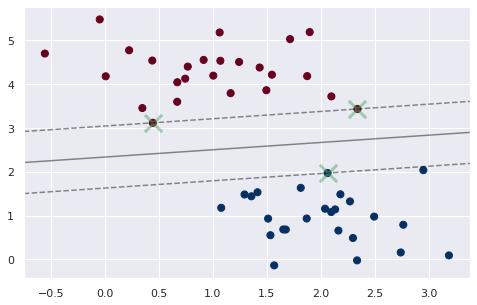

In [18]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')
plot_svc_decision_function(model);

Text(0.5, 1.0, 'decision values against feature[1] at feature[0]=1.0')

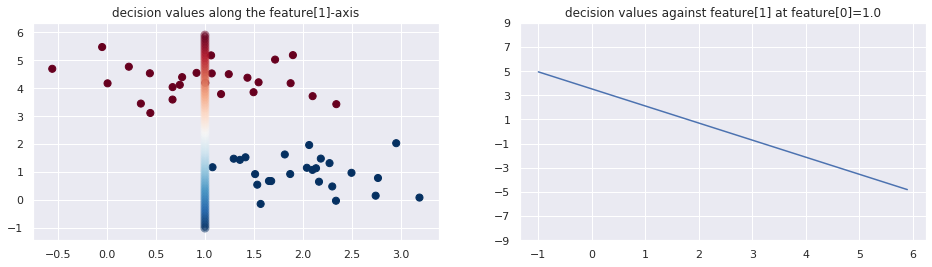

In [19]:
fy = np.arange(-1,6,0.1)
fx = 1.0 * np.ones(fy.shape[0])
feat = np.vstack ( (fx, fy) ).T
#print (feat.shape, feat[:4])
#
decision_values = model.decision_function (feat)
#
#
fig, ax = plt.subplots(1,2, figsize=(16,4))
ax[0].scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')
ax[0].scatter (fx, fy, c=decision_values, linewidth=3, alpha=0.5, cmap='RdBu')
ax[0].set_title ('decision values along the feature[1]-axis')
ax[1].plot(fy, decision_values)
ax[1].set_yticks(np.arange(-9, 11, 2))
ax[1].set_title ('decision values against feature[1] at feature[0]=1.0')

We may examine the decision boundary in the feature map with another method.

(20000, 2)
@ sanity check:  20000 (20000,)


Text(0.5, 1.0, 'SVC decision boundary.')

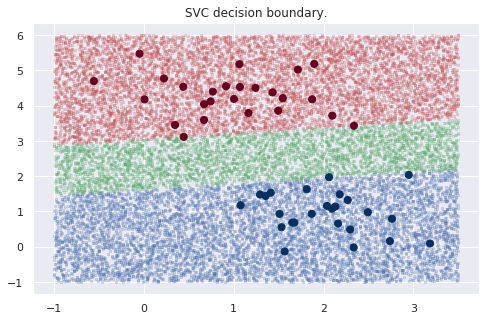

In [20]:
Nr=20000
fx = np.random.uniform(low=-1, high=3.5, size=Nr)
fy = np.random.uniform(low=-1, high=6, size=Nr)
fX = np.vstack( (fx, fy) ).T
print (fX.shape)
df = model.decision_function(fX)
df_p1 = df > 1
df_m1 = df < -1
df_margin = np.logical_and( df <= 1, df >= -1)
print('@ sanity check: ', df_p1.sum() + df_m1.sum() + df_margin.sum(), df_p1.shape )
plt.scatter (fx[df_p1], fy[df_p1], c='b', alpha=0.2, marker='s', s=2)
plt.scatter (fx[df_m1], fy[df_m1], c='r', alpha=0.2, marker='s', s=2)
plt.scatter (fx[df_margin], fy[df_margin], c='g', alpha=0.2, marker='s', s=2)
plt.scatter (X[:,0], X[:,1], c=y, s=50, cmap='RdBu')
plt.title('SVC decision boundary.')

This is the dividing line that maximizes the margin between the two sets of points.
Notice that a few of the training points just touch the margin: they are indicated by the black circles in this figure.
These points are the pivotal elements of this fit, and are known as the *support vectors*, and give the algorithm its name.
In Scikit-Learn, the identity of these points are stored in the ``support_vectors_`` attribute of the classifier:

In [21]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

A key to this classifier's success is that for the fit, only the position of the support vectors matter; any points further from the margin which are on the correct side do not modify the fit!
Technically, this is because these points do not contribute to the loss function used to fit the model, so their position and number do not matter so long as they do not cross the margin.

We can see this, for example, if we plot the model learned from the first 60 points and first 120 points of this dataset:

SV with 60 data
 [[0.44359863 3.11530945]
 [1.25566754 3.38204112]
 [0.83685684 2.13635938]]
SV with 120 data
 [[0.44359863 3.11530945]
 [1.25566754 3.38204112]
 [0.83685684 2.13635938]]


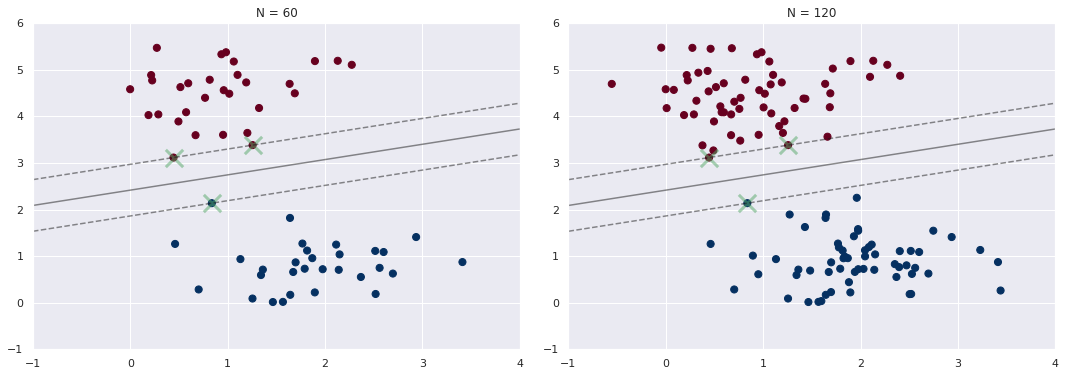

In [22]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)
    print (f'SV with {N} data\n', model.support_vectors_)
#
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

In the left panel, we see the model and the support vectors for 60 training points.
In the right panel, we have doubled the number of training points, but the model has not changed: the three support vectors from the left panel are still the support vectors from the right panel.
This insensitivity to the exact behavior of distant points is one of the strengths of the SVM model.

If you are running this notebook live, you can use IPython's interactive widgets to view this feature of the SVM model interactively:

In [23]:
from ipywidgets import interact, fixed
interact(plot_svm, N=[10, 200], ax=fixed(None));

interactive(children=(Dropdown(description='N', options=(10, 200), value=10), Output()), _dom_classes=('widget…

### Beyond linear boundaries: Kernel SVM

Where SVM becomes extremely powerful is when it is combined with *kernels*.
We have seen a version of kernels before, in the basis function regressions of [In Depth: Linear Regression](05.06-Linear-Regression.ipynb).
There we projected our data into higher-dimensional space defined by polynomials and Gaussian basis functions, and thereby were able to fit for nonlinear relationships with a linear classifier.

In SVM models, we can use a version of the same idea.
To motivate the need for kernels, let's look at some data that is not linearly separable:

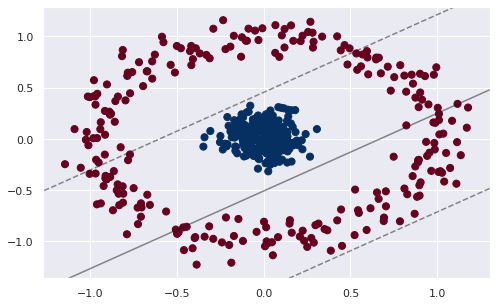

In [24]:
from sklearn.datasets.samples_generator import make_circles
X, y = make_circles(500, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')
plot_svc_decision_function(clf, plot_support=False);

It is clear that no linear discrimination will *ever* be able to separate this data.
But we can draw a lesson from the basis function regressions in [In Depth: Linear Regression](05.06-Linear-Regression.ipynb), and think about how we might project the data into a higher dimension such that a linear separator *would* be sufficient.
For example, one simple projection we could use would be to compute a *radial basis function* centered on the middle clump:

In [25]:
r = np.exp(-(X ** 2).sum(axis=1))

We can visualize this extra data dimension using a three-dimensional plot—if you are running this notebook live, you will be able to use the sliders to rotate the plot:

In [26]:
from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='RdBu')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=[-90, -15, 0, 15, 90], azip=(-180, 180),
         X=fixed(X), y=fixed(y));

interactive(children=(Dropdown(description='elev', options=(-90, -15, 0, 15, 90), value=-90), IntSlider(value=…

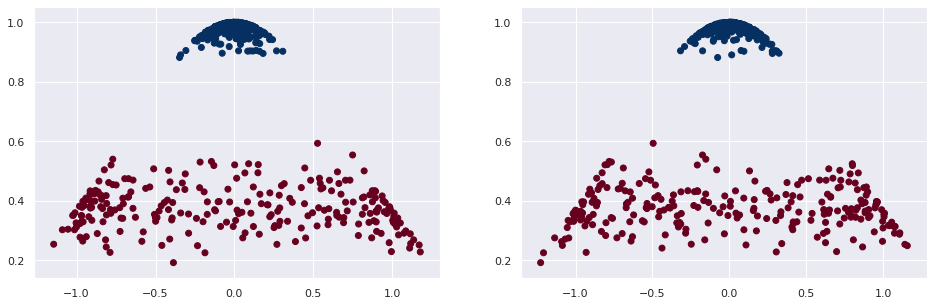

In [27]:
fig, ax = plt.subplots(1,2, figsize=(16,5))
ax[0].scatter(X[:,0], r, c=y, cmap='RdBu')
ax[1].scatter(X[:,1], r, c=y, cmap='RdBu')

We can see that with this additional dimension, the data becomes trivially linearly separable, by drawing a separating plane at, say, *r*=0.7.

Here we had to choose and carefully tune our projection: if we had not centered our radial basis function in the right location, we would not have seen such clean, linearly separable results.
In general, the need to make such a choice is a problem: we would like to somehow automatically find the best basis functions to use.

One strategy to this end is to compute a basis function centered at *every* point in the dataset, and let the SVM algorithm sift through the results.
This type of basis function transformation is known as a *kernel transformation*, as it is based on a similarity relationship (or kernel) between each pair of points.

A potential problem with this strategy—projecting $N$ points into $N$ dimensions—is that it might become very computationally intensive as $N$ grows large.
However, because of a neat little procedure known as the [*kernel trick*](https://en.wikipedia.org/wiki/Kernel_trick), a fit on kernel-transformed data can be done implicitly—that is, without ever building the full $N$-dimensional representation of the kernel projection!
This kernel trick is built into the SVM, and is one of the reasons the method is so powerful.

In Scikit-Learn, we can apply kernelized SVM simply by changing our linear kernel to an RBF (radial basis function) kernel, using the ``kernel`` model hyperparameter:

In [28]:
clf = SVC(kernel='rbf', C=1E6, gamma='scale')
clf.fit(X, y)

SVC(C=1000000.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

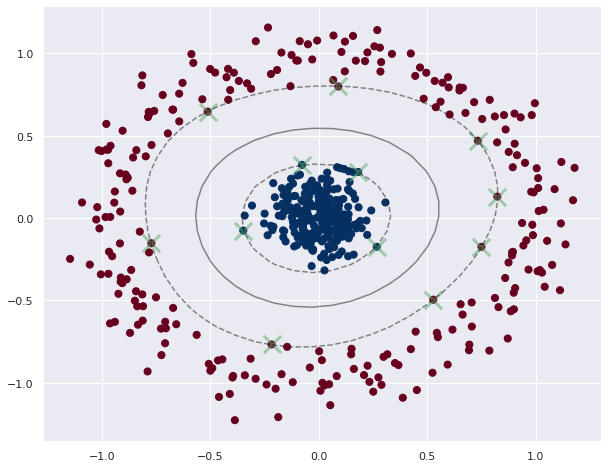

In [29]:
plt.figure(figsize=(10,8))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

Using this kernelized support vector machine, we learn a suitable nonlinear decision boundary.
This kernel transformation strategy is used often in machine learning to turn fast linear methods into fast nonlinear methods, especially for models in which the kernel trick can be used.

### Tuning the SVM: Softening Margins

Our discussion thus far has centered around very clean datasets, in which a perfect decision boundary exists.
But what if your data has some amount of overlap?
For example, you may have data like this:

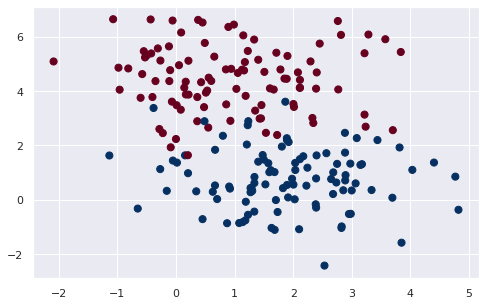

In [30]:
X, y = make_blobs(n_samples=200, centers=2,
                  random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu');

To handle this case, the SVM implementation has a bit of a fudge-factor which "softens" the margin: that is, it allows some of the points to creep into the margin if that allows a better fit.
The hardness of the margin is controlled by a tuning parameter, most often known as $C$.
For very large $C$, the margin is hard, and points cannot lie in it.
For smaller $C$, the margin is softer, and can grow to encompass some points.

The plot shown below gives a visual picture of how a changing $C$ parameter affects the final fit, via the softening of the margin:

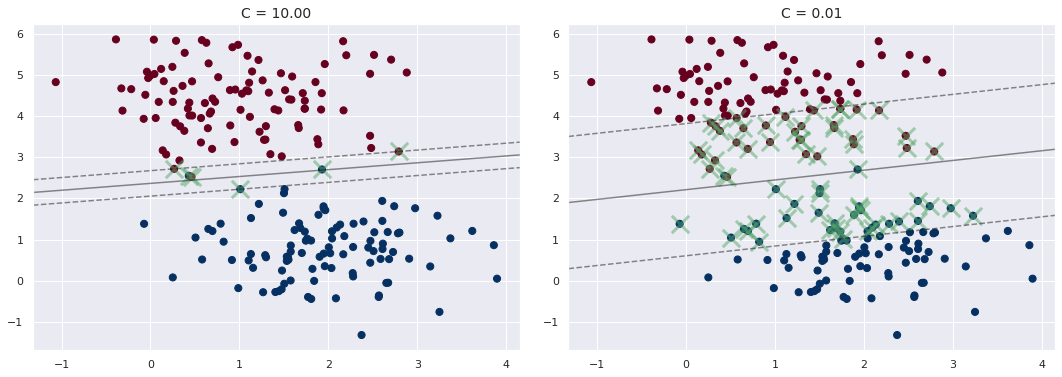

In [31]:
X, y = make_blobs(n_samples=200, centers=2,
                  random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.01]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')
    plot_svc_decision_function(model, axi)
#     axi.scatter(model.support_vectors_[:, 0],
#                 model.support_vectors_[:, 1],
#                 s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.2f}'.format(C), size=14)

The optimal value of the $C$ parameter will depend on your dataset, and should be tuned using cross-validation or a similar procedure (refer back to [Hyperparameters and Model Validation](05.03-Hyperparameters-and-Model-Validation.ipynb)).

## Example: Face Recognition

- See the [User Guide](https://scikit-learn.org/stable/datasets/index.html#labeled-faces-in-the-wild-dataset) in scikit-learn.org

As an example of support vector machines in action, let's take a look at the facial recognition problem.
We will use the Labeled Faces in the Wild dataset, which consists of several thousand collated photos of various public figures.
A fetcher for the dataset is built into Scikit-Learn:

In [45]:
import os, ssl
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and
    getattr(ssl, '_create_unverified_context', None)): 
    ssl._create_default_https_context = ssl._create_unverified_context


from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60, download_if_missing=True)
print(faces.target_names)
print(faces.images.shape, faces.data.shape)
print(np.unique(faces.target, return_counts=True))

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Junichiro Koizumi' 'Tony Blair']
(1277, 62, 47) (1277, 2914)
(array([0, 1, 2, 3, 4, 5, 6]), array([ 77, 236, 121, 530, 109,  60, 144]))


Let's plot a few of these faces to see what we're working with:

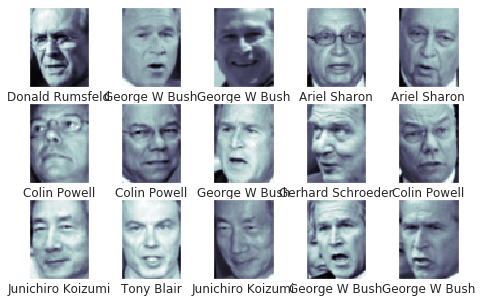

In [46]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

Each image contains [62×47] or nearly 3,000 pixels.
We could proceed by simply using each pixel value as a feature, but often it is more effective to use some sort of preprocessor to extract more meaningful features; here we will use a principal component analysis (see [In Depth: Principal Component Analysis](05.09-Principal-Component-Analysis.ipynb)) to extract 150 fundamental components to feed into our support vector machine classifier.
We can do this most straightforwardly by packaging the preprocessor and the classifier into a single pipeline:

In [48]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

pca = PCA(n_components=150, whiten=True, svd_solver='randomized', random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced', )
model = make_pipeline(pca, svc)

For the sake of testing our classifier output, we will split the data into a training and testing set:

In [50]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                                random_state=42)

Finally, we can use a grid search cross-validation to explore combinations of parameters.
Here we will adjust ``C`` (which controls the margin hardness) and ``gamma`` (which controls the size of the radial basis function kernel), and determine the best model:

In [54]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid, cv=5, iid=False)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: user 1min 50s, sys: 1min 43s, total: 3min 34s
Wall time: 36.5 s
{'svc__C': 1, 'svc__gamma': 0.005}


The optimal values fall toward the middle of our grid; if they fell at the edges, we would want to expand the grid to make sure we have found the true optimum.

Now with this cross-validated model, we can predict the labels for the test data, which the model has not yet seen:

In [55]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

Let's take a look at a few of the test images along with their predicted values:

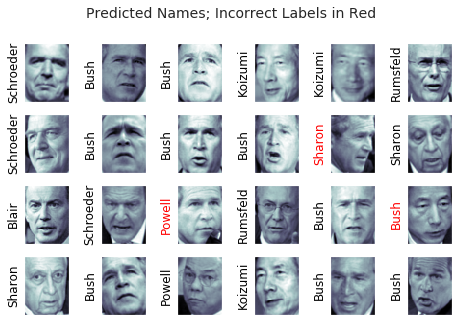

In [56]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

Out of this small sample, our optimal estimator mislabeled only a single face (Bush’s
face in the bottom row was mislabeled as Blair).
We can get a better sense of our estimator's performance using the classification report, which lists recovery statistics label by label:

In [58]:
from sklearn.metrics import classification_report
#
report = classification_report(ytest, yfit,target_names=faces.target_names)
print(report)

                   precision    recall  f1-score   support

     Ariel Sharon       0.67      0.62      0.64        13
     Colin Powell       0.71      0.88      0.78        66
  Donald Rumsfeld       0.86      0.63      0.73        30
    George W Bush       0.93      0.91      0.92       139
Gerhard Schroeder       0.95      0.88      0.91        24
Junichiro Koizumi       1.00      0.76      0.87        17
       Tony Blair       0.84      0.87      0.86        31

         accuracy                           0.85       320
        macro avg       0.85      0.79      0.82       320
     weighted avg       0.86      0.85      0.85       320



We might also display the confusion matrix between these classes:

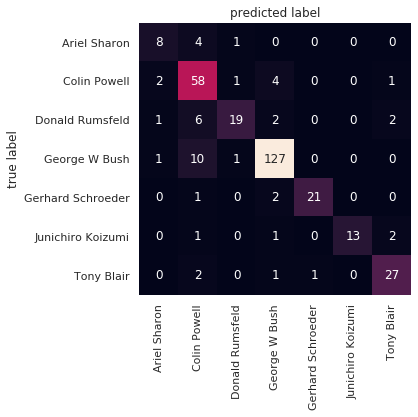

In [63]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
ax=sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,
                    xticklabels=faces.target_names,
                    yticklabels=faces.target_names)
bottom, top = ax.get_ylim() # due to a bug in matplotlib 3.1.0 and 3.1.1, 3.1.2 will fix it.
ax.set_ylim(bottom + 0.5, top - 0.5) # due to a bug in matplotlib 3.1.0 and 3.1.1
plt.ylabel('true label')
plt.title('predicted label');

This helps us get a sense of which labels are likely to be confused by the estimator.

For a real-world facial recognition task, in which the photos do not come pre-cropped into nice grids, the only difference in the facial classification scheme is the feature selection: you would need to use a more sophisticated algorithm to find the faces, and extract features that are independent of the pixellation.
For this kind of application, one good option is to make use of [OpenCV](http://opencv.org), which, among other things, includes pre-trained implementations of state-of-the-art feature extraction tools for images in general and faces in particular.

## Support Vector Machine Summary

We have seen here a brief intuitive introduction to the principals behind support vector machines.
These methods are a powerful classification method for a number of reasons:

- Their dependence on relatively few support vectors means that they are very compact models, and take up very little memory.
- Once the model is trained, the prediction phase is very fast.
- Because they are affected only by points near the margin, they work well with high-dimensional data—even data with more dimensions than samples, which is a challenging regime for other algorithms.
- Their integration with kernel methods makes them very versatile, able to adapt to many types of data.

However, SVMs have several disadvantages as well:

- The scaling with the number of samples $N$ is $\mathcal{O}[N^3]$ at worst, or $\mathcal{O}[N^2]$ for efficient implementations. For large numbers of training samples, this computational cost can be prohibitive.
- The results are strongly dependent on a suitable choice for the softening parameter $C$. This must be carefully chosen via cross-validation, which can be expensive as datasets grow in size.
- The results do not have a direct probabilistic interpretation. This can be estimated via an internal cross-validation (see the ``probability`` parameter of ``SVC``), but this extra estimation is costly.

With those traits in mind, I generally only turn to SVMs once other simpler, faster, and less tuning-intensive methods have been shown to be insufficient for my needs.
Nevertheless, if you have the CPU cycles to commit to training and cross-validating an SVM on your data, the method can lead to excellent results.

<!--NAVIGATION-->
< [In Depth: Linear Regression](05.06-Linear-Regression.ipynb) | [Contents](Index.ipynb) | [In-Depth: Decision Trees and Random Forests](05.08-Random-Forests.ipynb) >

<a href="https://colab.research.google.com/github/yongduek/PythonDataScienceHandbook/blob/master/notebooks/05.07-Support-Vector-Machines.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>


## Q1. Apply SVC to hand-written digits dataset.
- The data set has $8\times8$ images of numbers.
- You must split the data into train and test sets
- apply cross-validation for evaluation of the model.

In [68]:
import sklearn.datasets as datasets
digits = datasets.load_digits()
digits.data.shape

(1797, 64)

## Q2. Apply SVC to MNIST dataset
- https://scikit-learn.org/stable/auto_examples/linear_model/plot_sparse_logistic_regression_mnist.html
Many options to get the data
1. `sklearn.datasets.fetch_openml` - (warning! it maybe very slow)
2. install `torch` and `torchvision` from `www.pytorch.org`

In [118]:
# 1. using fetch_openml
from sklearn.datasets import fetch_openml
mnist = fetch_openml (name='mnist_784', version=1)
X = mnist.data
y = mnist.target

In [81]:
print(dir(mnist), mnist.data.shape)

['DESCR', 'categories', 'data', 'details', 'feature_names', 'target', 'url'] (70000, 784)


In [85]:
random_state = sklearn.utils.check_random_state(0)
permutation = random_state.permutation(X.shape[0])
X = X[permutation]
y = y[permutation]
X = X.reshape((X.shape[0], -1))

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=60000, test_size=10000)
X_train.shape, X_test.shape

((60000, 784), (10000, 784))

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
target:  5


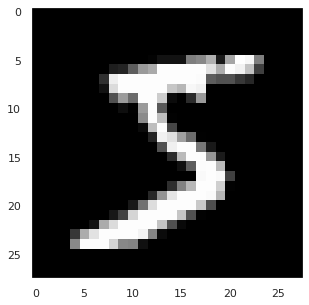

In [117]:
# 2. Using pytorch
import torch
import torchvision
mnist_trainset = torchvision.datasets.MNIST('./data', train=True, download=True)
mnist_testset  = torchvision.datasets.MNIST('./data', train=False, download=True)
X_train, y_train = mnist_trainset.data.numpy(), mnist_trainset.targets.numpy()
X_test, y_test = mnist_testset.data.numpy(), mnist_testset.targets.numpy()
#
print( X_train.shape, y_train.shape, X_test.shape, y_test.shape)
plt.imshow (X_train[0], cmap='gray')
print ('target: ', y_train[0])

## Q3. Do Classification for KMNIST dataset
- Use `torchvision` in `pytorch`. You need to install torch and torchvision from `www.pytorch.org` if you want to use the code snipet below. 
- You may access directly the KMNIST repository: https://github.com/rois-codh/kmnist
![](kmnist_examples.png)
The 10 classes of Kuzushiji-MNIST, with the first column showing each character's modern hiragana counterpart. 

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


Text(0.5, 0.98, 'Samples of KMNIST training data')

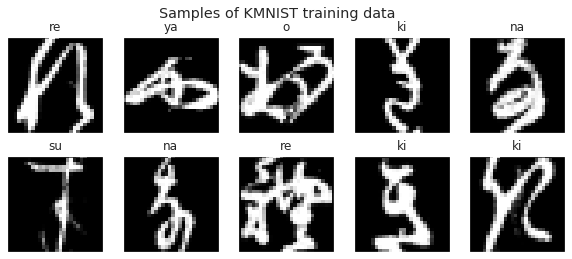

In [151]:
sns.set(style='dark')
import torch
import torchvision
trainset = torchvision.datasets.KMNIST('./data', train=True, download=True)
testset  = torchvision.datasets.KMNIST('./data', train=False, download=True)
X_train, y_train = trainset.data.numpy(), trainset.targets.numpy()
X_test, y_test = testset.data.numpy(), testset.targets.numpy()
#
print( X_train.shape, y_train.shape, X_test.shape, y_test.shape)
fig, axes = plt.subplots(2,5, figsize=(10,4))
for i, ax in enumerate(axes.ravel()):
    ax.imshow (X_train[i], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(trainset.classes[ y_train[i] ])
fig.suptitle('Samples of KMNIST training data')

## Q4. Do Classification for CIFAR-10 dataset
- Use `torchvision` in `pytorch`. You need to install torch and torchvision from `www.pytorch.org` if you want to use the code snipet below. 
- https://www.cs.toronto.edu/~kriz/cifar.html
![](cifar_10.png)

Files already downloaded and verified
Files already downloaded and verified
(50000, 32, 32, 3) (50000,) (10000, 32, 32, 3) (10000,)


Text(0.5, 0.98, 'Samples from CIFAR10 training data')

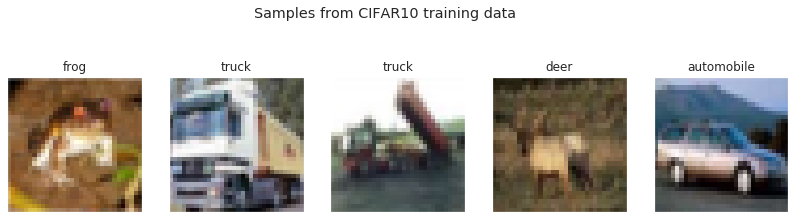

In [152]:
sns.set(style='dark')
import torch
import torchvision
trainset = torchvision.datasets.CIFAR10('./data', train=True, download=True)
testset  = torchvision.datasets.CIFAR10('./data', train=False, download=True)
X_train, y_train = trainset.data, np.array(trainset.targets)
X_test, y_test   = testset.data, np.array(testset.targets)
#
print( X_train.shape, y_train.shape, X_test.shape, y_test.shape)
fig, axes = plt.subplots(1,5, figsize=(14,4))
for i, ax in enumerate(axes.ravel()):
    ax.imshow (X_train[i], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(trainset.classes[y_train[i]])
fig.suptitle('Samples from CIFAR10 training data')
#

## Precision, Recall, F1

$$
    Precision = \frac{TP}{TP + FP}
\quad
    Recall = \frac{TP}{TP + TN}
\quad
    F1 = \frac{1}{ \frac{1}{2} (\frac{1}{Precision} + \frac{1}{Recall}) }
$$

![https://en.wikipedia.org/wiki/Precision_and_recall](precision_recall_diagram.png)
[See Wikipedia](https://en.wikipedia.org/wiki/Precision_and_recall) for the diagram.

---

## Extra Example

https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html#sphx-glr-auto-examples-applications-plot-face-recognition-py


Automatically created module for IPython interactive environment
Total dataset size:
n_samples: 1217
n_features: 1850
n_classes: 6
Extracting the top 150 eigenfaces from 912 faces
done in 0.522s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.010s
Fitting the classifier to the training set
done in 23.236s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.005, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Predicting people's names on the test set
done in 0.039s
                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.43      0.60        14
     Colin Powell       0.88      0.78      0.83        65
  Donald Rumsfeld       0.92      0.67      0.77        33
    George W Bush       0.77      0.98      0.86       133
Gerhard Schroeder       0.94      0.74  

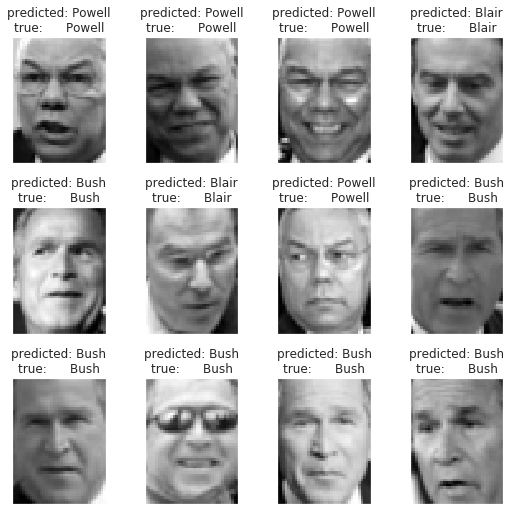

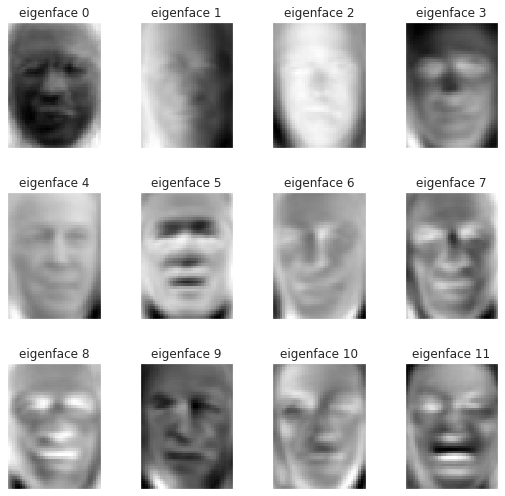

In [64]:
from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC


print(__doc__)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')


# #############################################################################
# Download the data, if not already on disk and load it as numpy arrays

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)


# #############################################################################
# Split into a training set and a test set using a stratified k fold

# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)


# #############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))


# #############################################################################
# Train a SVM classification model

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                   param_grid, cv=5, iid=False)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)


# #############################################################################
# Quantitative evaluation of the model quality on the test set

print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))


# #############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

---

## Other Classifiers
- random forest classifier: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
- multilayer perceptron
- k-Neighbors 
- decision tree
- SGDClassifier: [document is here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier)

See [sklearn's comparison of classifiers](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html#sphx-glr-auto-examples-classification-plot-classifier-comparison-py)

![](sphx_glr_plot_classifier_comparison_001.png)

EOF